In [1]:
import numpy as np

import argparse, cv2, os, sys, math, random

from pathlib import *

from matplotlib import pyplot as plt

from PIL import Image

from scipy import ndimage

# cm, pgg, cmm

In [2]:
# general function: 


def rec_crop(image,width,height): # crop a rectangular area 
    h,w = image.shape[:2]
    x=int(np.random.rand(1)*(w-width))
    y=int(np.random.rand(1)*(h-height))
    img_cropped = np.copy(image[y:y+height, x:x+width])
    return img_cropped

def translate_normal(image, W, H):
    (h,w)=image.shape[:2]
    times_H = int(H/h)+1
    times_W = int(W/w)+1  
    p1=image
    for j in range(1,times_H):
        p1=np.concatenate((p1,image))       
    p2=p1   
    for i in range(1,times_W):
        p2=np.concatenate((p2, p1),axis=1)   
    img_trans = p2[:H, :W] 
    return img_trans

# Specfic function:

In [3]:
# cm: 
def rhomb_crop(image):
    crop1 = np.copy(image)
    
    (b,a)=crop1.shape[:2]
    w,h = a,b
    crop2=np.copy(crop1)
    for n in range (0,2):
        for i in range (0,int(h/2)):
            crop2[i,0:int(w/2-i*w/h),:]=0
            crop2[i,int(w/2+i*w/h):w,:]=0
        crop2=np.rot90(crop2,2)     
    return crop2

def cm_rec_hori(crop1): #crop a rhombic shape image 
    h = crop1.shape[0]
    img_1=np.copy(crop1[:int(h/2),:,:])
    img_2 = cv2.flip(img_1,0,dst=None) 
    img = np.vstack((img_1,img_2))        
    return img

def rhombic_unit(crop):  
    #roll and fill the four corner to create a unit that can be translated
    h,w=crop.shape[:2]
    roll0 = np.roll(np.roll(crop, round(h/2), axis=0), round(w/2), axis=1)
    merged=np.copy(crop)
    for i in range (0,h):
        for j in range (0,w):
            if np.sum(merged[i,j,:])==0:
                merged[i,j,:]=np.copy(roll0[i,j,:])
    return merged

def rhombic_edge(image):
    img = np.copy(image)
    h,w = img.shape[:2]
    times = 1
    for i in range (0,int(h/2)):
        for j in range (0,int(w/2)):
            if np.sum(img[i,j,:])==0:
                t=1
                i_h = i
                if i_h < h-1:
                    while np.sum(img[i_h+1,j,:])==0:
                        t=t+1
                        i_h = i_h+1
                    if t > times:
                        times = t
    for q in range(0,times):
        img_1 = np.roll(img,1,axis=0)
        for i in range (0,h):
            for j in range (0,w):
                if np.sum(img[i,j,:])==0:
                    img[i,j,:]=np.copy(img_1[i,j,:])
    return img

def cm_horizontal(image,unit_w,unit_h,Width,Height):
    crop_rec = rec_crop(image, unit_w, unit_h)
    img_cm_rec_hori = cm_rec_hori(crop_rec)
    img_cm_rhomb_hori = rhomb_crop(img_cm_rec_hori)
    unit_cm_hori = rhombic_unit(img_cm_rhomb_hori)
    cm_hori = translate_normal(unit_cm_hori,Width,Height)   
    cm_hori = rhombic_edge(cm_hori) # take care of edge of unit cells
    return cm_hori

def cm_vertical(image,unit_w,unit_h,Width,Height):
    crop_rec = rec_crop(image, unit_w, unit_h)
    crop_rec = np.rot90(crop_rec)
    #rotate to vertical direction and do the same procedures
    img_cm_rec_verti = cm_rec_hori(crop_rec)
    img_cm_rhomb_verti = rhomb_crop(img_cm_rec_verti)
    unit_cm_verti = rhombic_unit(img_cm_rhomb_verti)
    unit_cm_verti = np.rot90(unit_cm_verti)
    cm_verti = translate_normal(unit_cm_verti,Width,Height)   
    cm_verti = rhombic_edge(cm_verti)
    return cm_verti

In [4]:
# pgg:
def pgg_rec(crop1): # crop a pgg rhombic shape image 
    (b,a)=crop1.shape[:2]
    w,h = a,b
    crop2=np.copy(crop1[:int(h/2),:w,:])
    crop3=np.rot90(crop2,2)
    crop4=np.vstack((crop2,crop3))
    return crop4

def pgg_rhombic_unit(rhombic):  
    # roll and fill the four corner to create a unit that can be translated
    h,w=rhombic.shape[:2]
    p1 = np.copy(rhombic[:int(h/2),:,:])
    p2 = np.copy(rhombic[int(h/2):h,:,:])   
    r_p1 = cv2.flip(p1,0,dst=None) # horizontal flip
    r_p2 = cv2.flip(p2,0,dst=None)
    r = np.vstack((r_p2,r_p1))      
    h,w=r.shape[:2]
    rolled = np.roll(np.roll(r, int(h/2), axis=0), int(w/2), axis=1)
    for i in range (0,h):
        for j in range (0,w):
            if np.sum(rhombic[i,j,:])==0:
                rhombic[i,j,:]=np.copy(rolled[i,j,:])
    return rhombic

def pgg(image,unit_w,unit_h,Width,Height):
    crop_rec = rec_crop(image, unit_w, unit_h)
    img_pgg_rec = pgg_rec(crop_rec)
    img_pgg_rhomb = rhomb_crop(img_pgg_rec)
    unit_pgg = pgg_rhombic_unit(img_pgg_rhomb)
    pgg = translate_normal(unit_pgg,Width,Height)
    pgg = rhombic_edge(pgg)
    return pgg

In [5]:
# cmm:   when width = height, it would be cmm square
def rhombic_unit_cmm(crop):      
    h,w=crop.shape[:2]    
    if h==w:
        u1 = Image.fromarray(crop)
        u2 = u1.rotate(45)
        u3 = np.array(u2)
        for i in range (0,4):
            hh,ww = u3.shape[:2]
            while np.sum(u3[0,:,:])==0:
                u3 = np.copy(u3[1:hh])
            u3 = np.copy(u3[1:hh])
            u3 = np.rot90(u3)
        unit = np.copy(u3)
    else:    
    #roll and fill the four corner to create a unit that can be translated
        h,w=crop.shape[:2]
        rolled = np.roll(np.roll(crop, int(h/2), axis=0), int(w/2), axis=1)
        merged=np.copy(crop)
        for i in range (0,h):
            for j in range (0,w):
                if np.sum(merged[i,j,:])==0:
                    merged[i,j,:]=np.copy(rolled[i,j,:])
        unit = np.copy(merged)
    return unit

def rhomb_crop(image):
    (h,w)=image.shape[:2]
    
    crop2=np.copy(image)
    for n in range (0,2):
        for i in range (0,int(h/2)):
            crop2[i,0:int(w/2-i*w/h),:]=0
            crop2[i,int(w/2+i*w/h):w,:]=0
        crop2=np.rot90((crop2),2)
        
    return crop2

def cmm_rhomb(reg_rhomb):
    h,w = reg_rhomb.shape[:2]
    left = np.copy(reg_rhomb[:, :int(w/4), :])
    right = np.copy(reg_rhomb[:, int(3*w/4):w, :])
    top = np.copy(reg_rhomb[:int(h/4), int(w/4):int(3*w/4), :])
    under = np.copy(reg_rhomb[int(3*h/4):h, int(w/4):int(3*w/4), :])  
    c1 = np.copy(reg_rhomb[int(h/4):int(h/2), int(w/4):int(w/2), :])
    c2 = cv2.flip(c1,1,dst=None) 
    c3 = cv2.flip(c1,0,dst=None) 
    c4 = cv2.flip(c2,0,dst=None)
    b,a = c1.shape[:2]  
    central = np.copy(reg_rhomb[int(h/4):int(3*h/4), int(w/4):int(3*w/4),:])
    central [:b, -a:, :] = np.copy(c2)
    central [-b:, :a, :] = np.copy(c3)
    central [-b:, -a:, :] = np.copy(c4)
    middle = np.vstack((top, central, under))
    cmm_rhomb = np.hstack((left, middle, right))
    return cmm_rhomb

def cmm(image,unit_w,unit_h,Width,Height):
    crop_rec = rec_crop(image, unit_w, unit_h)
    rhomb = rhomb_crop(crop_rec)
    crop_rhomb_cmm = cmm_rhomb(rhomb)
    unit_cmm = rhombic_unit_cmm(crop_rhomb_cmm)
    img_cmm = translate_normal(unit_cmm,Width,Height)
    img_cmm = border_cmm(img_cmm)
    return img_cmm

def border_cmm(image): # vague the border
    h,w = image.shape[:2]
    for i in range (0,h-1):
        for j in range (1,w-1):
            if np.sum(image[i,j,:])==0:
                if np.sum(image[i,j-1,:])!=0 and np.sum(image[i,j+1,:])!=0:
                    image[i,j,:] = np.copy(image[i,j+1,:])
                if np.sum(image[i-1,j,:])!=0 and np.sum(image[i+1,j,:])!=0:
                    image[i,j,:] = np.copy(image[i+1,j,:])
                
    for i in range (1,h):
        for j in range (1,w-1): 
            if np.sum(image[i,j,:])==0:
                if np.sum(image[i-1,1,:])!=0 and np.sum(image[i,j-1,:])!=0:
                    image[i,j,:] = np.copy(image[i-1,j-1,:])
                if np.sum(image[i-1,j,:])!=0 and np.sum(image[i,j+1,:])!=0:
                    image[i,j,:] = np.copy(image[i-1,j+1,:])
                
    for i in range (0,h-1):
        for j in range (1,w-1): 
            if np.sum(image[i,j,:])==0:
                if np.sum(image[i+1,j,:])!=0 and np.sum(image[i,j+1,:])!=0:
                    image[i,j,:] = np.copy(image[i+1,j+1,:])
                if np.sum(image[i+1,j,:])!=0 and np.sum(image[i,j-1,:])!=0:
                    image[i,j,:] = np.copy(image[i+1,j-1,:])
                
    for i in range (1,h-1):
        for j in range (1,w):           
            if np.sum(image[i,j,:])==0:
                if np.sum(image[i-1,1,:])!=0 and np.sum(image[i,j-1,:])!=0:
                    image[i,j,:] = np.copy(image[i-1,j-1,:])
                if np.sum(image[i+1,j,:])!=0 and np.sum(image[i,j-1,:])!=0:
                    image[i,j,:] = np.copy(image[i+1,j-1,:])
                                       
    for i in range (1,h-1):
        for j in range (0,w-1): 
            if np.sum(image[i,j,:])==0:
                if np.sum(image[i+1,j,:])!=0 and np.sum(image[i,j+1,:])!=0:
                    image[i,j,:] = np.copy(image[i+1,j+1,:])
                if np.sum(image[i-1,j,:])!=0 and np.sum(image[i,j+1,:])!=0:
                    image[i,j,:] = np.copy(image[i-1,j+1,:]) 
                                       
    return image

# Validate with image sample

In [6]:
import cv2, math, os, random
import numpy as np
import matplotlib.pyplot as plt

# Load image

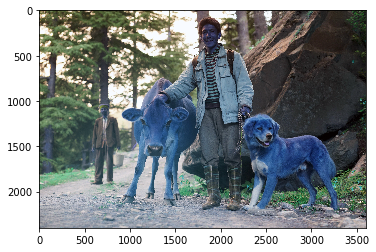

In [7]:
# use image samples for demontration
ori = cv2.imread('/home/yig319/Dropbox/wallpaper_group_generator/Original_images/dog-park.png') 
image1 = np.copy(ori) # load image used to crop and transform
imgplot = plt.imshow(image1)

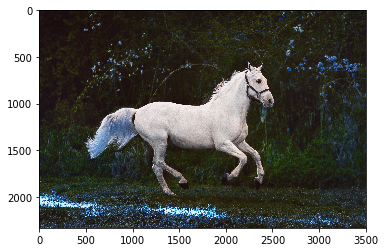

In [8]:
# use image samples for demontration
ori = cv2.imread('/home/yig319/Dropbox/wallpaper_group_generator/Original_images/horse.png') 
image2 = np.copy(ori) # load image used to crop and transform
imgplot = plt.imshow(image2)

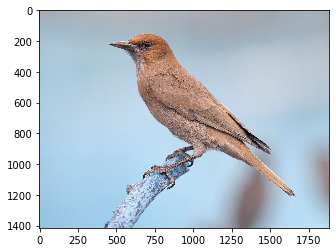

In [9]:
# use image samples for demontration
ori = cv2.imread('/home/yig319/Dropbox/wallpaper_group_generator/Original_images/bird.png') 
image3 = np.copy(ori) # load image used to crop and transform
imgplot = plt.imshow(image3)

# Set image size

In [10]:
#set output image size 
width, height = (256, 256)

# use random size and angle as croped part of image
angle = random.randint(30,85)
unit_h = random.randint(20,80)
lower_bound_w = int(unit_h/math.tan(math.radians(angle)))
if lower_bound_w > 65:
    unit_w = random.randint(lower_bound_w+15, lower_bound_w+75)
else: 
    unit_w = random.randint(lower_bound_w+15, 85)
    
# width, length, angle of unit cell:
unit_w, unit_h, angle

(54, 62, 78)

# Transform

In [12]:
cm_1 = cm_horizontal(image1,unit_w,unit_h,width,height)
cm_2 = cm_vertical(image1,unit_w,unit_h,width,height)

pgg_1 = pgg(image1,unit_w,unit_h,width,height) 

cmm_1 = cmm(image1,unit_w,unit_h,width,height)

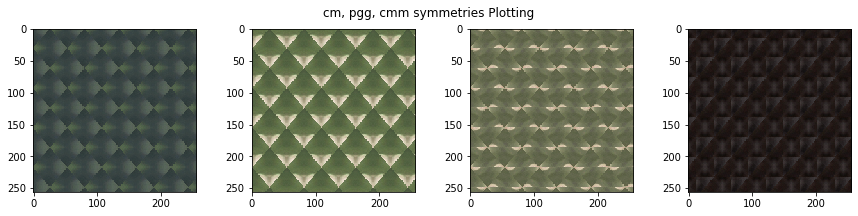

In [13]:
plt.figure(figsize=(15, 3))
plt.subplot(141)
plt.imshow(cm_1)
plt.subplot(142)
plt.imshow(cm_2)
plt.subplot(143)
plt.imshow(pgg_1)
plt.subplot(144)
plt.imshow(cmm_1)

plt.suptitle('cm, pgg, cmm symmetries Plotting')
plt.show()

In [14]:
cm_1 = cm_horizontal(image2,unit_w,unit_h,width,height)
cm_2 = cm_vertical(image2,unit_w,unit_h,width,height)

pgg_1 = pgg(image2,unit_w,unit_h,width,height) 

cmm_1 = cmm(image2,unit_w,unit_h,width,height)

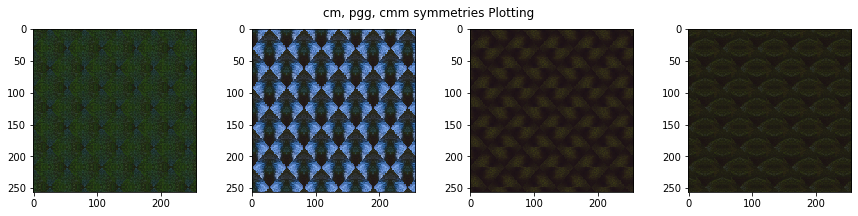

In [15]:
plt.figure(figsize=(15, 3))
plt.subplot(141)
plt.imshow(cm_1)
plt.subplot(142)
plt.imshow(cm_2)
plt.subplot(143)
plt.imshow(pgg_1)
plt.subplot(144)
plt.imshow(cmm_1)

plt.suptitle('cm, pgg, cmm symmetries Plotting')
plt.show()

In [16]:
cm_1 = cm_horizontal(image3,unit_w,unit_h,width,height)
cm_2 = cm_vertical(image3,unit_w,unit_h,width,height)

pgg_1 = pgg(image3,unit_w,unit_h,width,height) 

cmm_1 = cmm(image3,unit_w,unit_h,width,height)

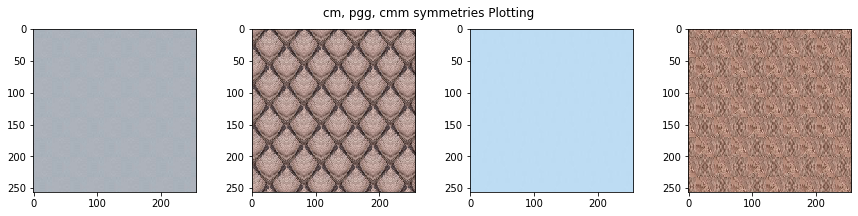

In [17]:
plt.figure(figsize=(15, 3))
plt.subplot(141)
plt.imshow(cm_1)
plt.subplot(142)
plt.imshow(cm_2)
plt.subplot(143)
plt.imshow(pgg_1)
plt.subplot(144)
plt.imshow(cmm_1)

plt.suptitle('cm, pgg, cmm symmetries Plotting')
plt.show()